In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from skfda.preprocessing.dim_reduction import FPCA
import torch
import torch.nn as nndata
import torch.optim as optim
from models_HLS import *
from data_generation_new import *
from utils import *
from training_HLS import *

In [2]:
J = 5
d =5000
#sigma = np.repeat(1,J)
psi1 = 0.5 * np.eye(J)
psi2 = -0.2 * np.eye(J)
sigma = 1.0 / np.arange(1, J + 1)
X_coef, F_basis, fd_basis = generate_far2_coef(d, J, Sigma=sigma, Psi1=psi1, Psi2=psi2, seed=10)
print(X_coef.shape)

norms of the basis are: [1. 1. 1. 1. 1.]
(5000, 5)


# Compute the true Long run covariance matrix on the Fourier Basis

In [3]:
center_dat_tensor = torch.tensor(X_coef, dtype=torch.float32)
center_dat_tensor.shape

torch.Size([5000, 5])

In [4]:
cov_weighted_true,_,_ =cov_l(center_dat_tensor , 0, round(d**(1/2)),  "Bartlett")
print((cov_weighted_true * 100).round() / 100)
sum(np.diag(cov_weighted_true))

tensor([[ 2.3800, -0.0100, -0.0900,  0.0300, -0.0600],
        [-0.0100,  0.6400,  0.0700,  0.0100, -0.0300],
        [-0.0900,  0.0700,  0.2100, -0.0200,  0.0000],
        [ 0.0300,  0.0100, -0.0200,  0.1500, -0.0100],
        [-0.0600, -0.0300,  0.0000, -0.0100,  0.0700]])


np.float32(3.4435465)

# Conduct FPCA

In [5]:
print("NaNs in coef:", np.isnan(X_coef).any())
print("Infs in coef:", np.isinf(X_coef).any())
print("Max abs coef:", np.abs(X_coef).max())

NaNs in coef: False
Infs in coef: False
Max abs coef: 4.234234279814813


In [6]:
# Conduct FPCA
fpca_fbasis = FPCA(n_components=3)
fpca_fbasis.fit(fd_basis)
scores = fpca_fbasis.transform(fd_basis)

# Explained variance ratio
print("Explained variance by each PC:", fpca_fbasis.explained_variance_ratio_)
print(sum(fpca_fbasis.explained_variance_ratio_))

Explained variance by each PC: [0.6869222  0.16740823 0.07608007]
0.9304104949648948


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: divide by zero encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: overflow encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: invalid value encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: divide by zero encountered in matmul
  X.coefficients @ self._j_matrix
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: overflow encountered in matmul
  X.coeffi

In [7]:
E_coef = fpca_fbasis.components_.coefficients 
print(E_coef)
E_coef.shape

[[ 9.99973622e-01  3.38266933e-03 -5.31221215e-03 -2.97502626e-03
  -2.05959882e-03]
 [-3.34020357e-03  9.99608235e-01  1.92888416e-02 -1.99853314e-02
  -8.64677032e-04]
 [ 5.47144717e-03 -1.89017644e-02  9.99396697e-01  1.72539875e-02
   2.28326412e-02]]


(3, 5)

In [8]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: F_basis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [9]:
Y_np.shape

(5000,)

In [10]:
scores.shape

(5000, 3)

In [11]:
center_dat = scores
center_dat.shape

(5000, 3)

In [12]:
X = torch.tensor(center_dat, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(d, 1)
print(Y.size())

torch.Size([5000, 3])
torch.Size([5000, 1])


# Model adding covariates

In [13]:
# Parameters
porder = 0
band = round(d**(1/3)) # the bandwidth
print(band)

17


In [14]:
cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
cov_weighted

tensor([[ 2.2531,  0.0105, -0.0593],
        [ 0.0105,  0.5520,  0.0057],
        [-0.0593,  0.0057,  0.2292]])

In [15]:
cov_weighted_np = cov_weighted.detach().numpy()
cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef
print("The estimated LR covariance matrix is:")
print(np.round(cov_weighted_transform,4))
print("The trace of the estimated LR covariance matrix is:")
print(sum(np.diag(cov_weighted_transform)))
print("The true LR covariance matrix is:")
print(np.round(cov_weighted_true.detach().numpy(),4))
print("The trace of the true LR covariance matrix is:")
print(sum(np.diag(cov_weighted_true)))

The estimated LR covariance matrix is:
[[ 2.2523e+00  1.7400e-02 -6.9800e-02 -7.9000e-03 -6.0000e-03]
 [ 1.7400e-02  5.5160e-01  1.1700e-02 -1.1100e-02 -5.0000e-04]
 [-6.9800e-02  1.1700e-02  2.3000e-01  3.8000e-03  5.4000e-03]
 [-7.9000e-03 -1.1100e-02  3.8000e-03  3.0000e-04  1.0000e-04]
 [-6.0000e-03 -5.0000e-04  5.4000e-03  1.0000e-04  1.0000e-04]]
The trace of the estimated LR covariance matrix is:
3.0342915207147594
The true LR covariance matrix is:
[[ 2.381  -0.0075 -0.0874  0.0314 -0.0599]
 [-0.0075  0.6369  0.0731  0.0079 -0.029 ]
 [-0.0874  0.0731  0.2081 -0.0177  0.0045]
 [ 0.0314  0.0079 -0.0177  0.1491 -0.005 ]
 [-0.0599 -0.029   0.0045 -0.005   0.0684]]
The trace of the true LR covariance matrix is:
3.4435465


Epoch [200/5000], Loss: 0.0077
Stopping early at Epoch [309/5000], Loss: 0.000097

Restoring best model weights...


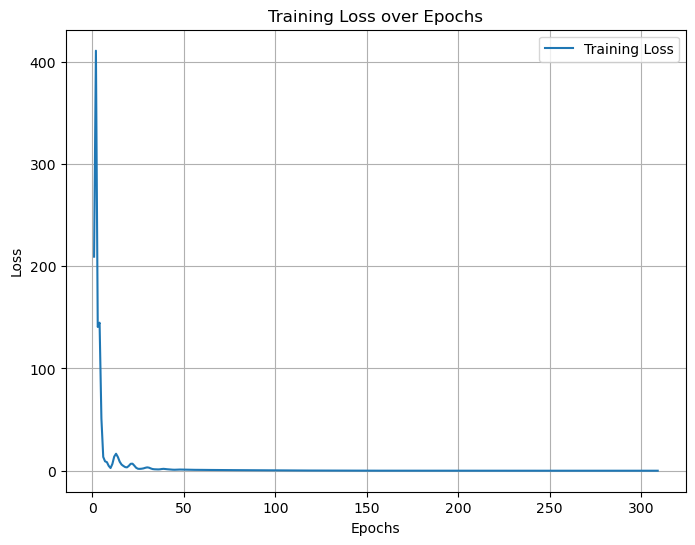

In [16]:
trained_model, losses, best_cov = train_model(
    X=X, Y=Y,
    ModelClass=Model1_new,
    porder=porder,
    band=band,
    kern_type= "Bartlett",
    hidden_dim=64,
    lr=0.01,
    epochs=5000,
    patience=300
)


Shape of Covariance Matrix (NumPy): (3, 3)


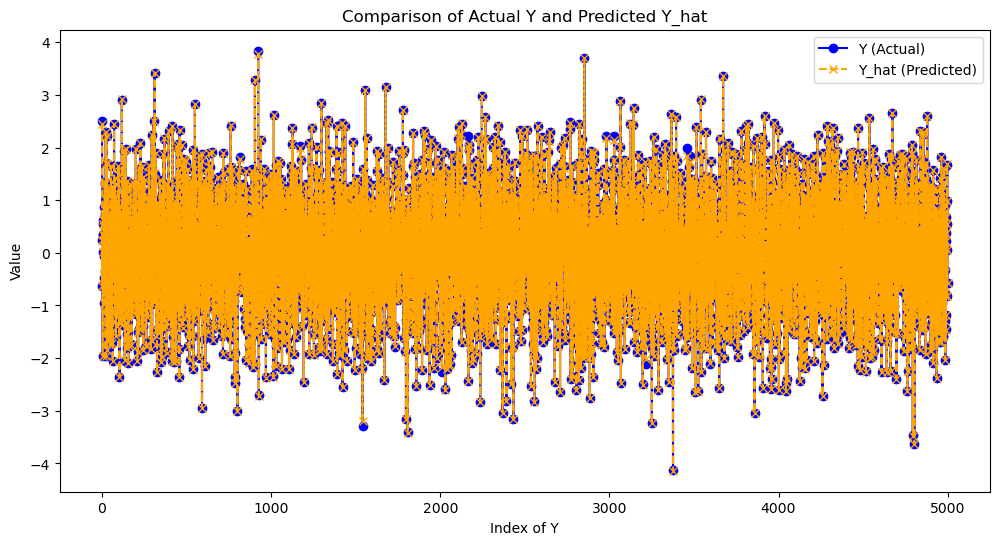

In [17]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
    cov_weighted_np = cov_weighted.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_weighted_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


# Compute true covariance matrix

In [18]:
N = 500
d_large = 100000
band = round(d_large ** (1 / 3))
kernel = "Bartlett"
filename = f"true_LRcov/empirical_cov_far2_N{N}_d{d_large}_band{band}_kernel{kernel}.csv"
boostrap_true = np.loadtxt(filename, delimiter=",")

print(boostrap_true)

[[ 2.03676939e+00 -9.32390220e-04 -9.33301228e-04 -1.07045831e-04
  -3.22859305e-05]
 [-9.32390220e-04  5.07718205e-01 -5.49122051e-05  4.90891252e-05
  -3.47273657e-04]
 [-9.33301228e-04 -5.49122051e-05  2.25909218e-01 -1.03161210e-06
   6.61308513e-05]
 [-1.07045831e-04  4.90891252e-05 -1.03161210e-06  1.27176300e-01
  -1.32812811e-05]
 [-3.22859305e-05 -3.47273657e-04  6.61308513e-05 -1.32812811e-05
   8.13614577e-02]]


In [19]:
print("Sum of diagonal (boostrap cov matrix):",np.trace(boostrap_true))
print("Sum of diagonal (true cov matrix from data):", np.trace(cov_weighted_true))
print("Sum of diagonal (estimated cov matrix from kernel sandwich method):",np.trace(cov_weighted))
print("Sum of diagonal (estimated cov matrix with all weights =1):",np.trace(cov_unweighted))

Sum of diagonal (boostrap cov matrix): 2.978934571146965
Sum of diagonal (true cov matrix from data): 3.4435465
Sum of diagonal (estimated cov matrix from kernel sandwich method): 3.0342915
Sum of diagonal (estimated cov matrix with all weights =1): 3.315869


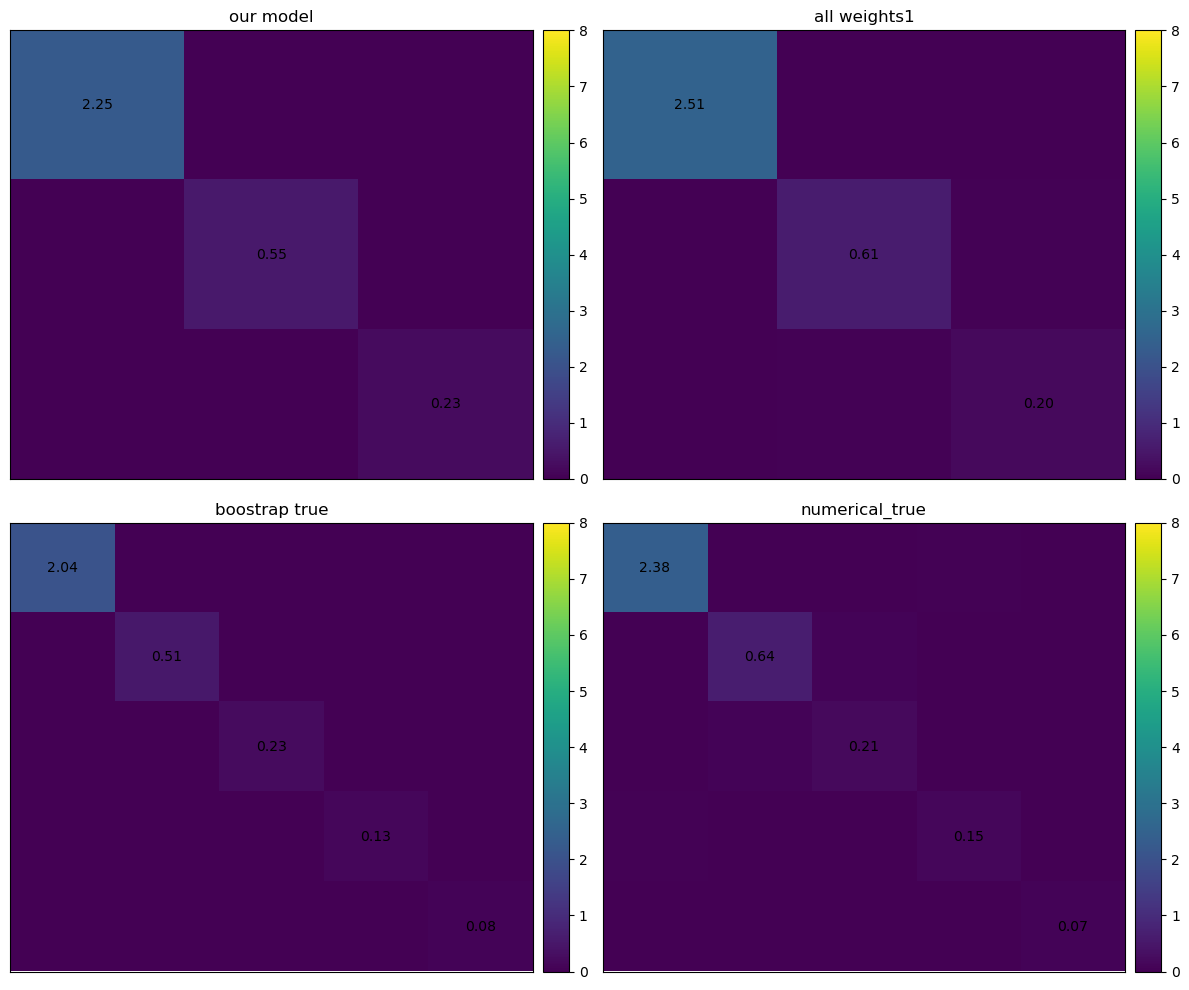

In [20]:
fig = plot_matrices_2d([cov_weighted,cov_unweighted, boostrap_true, cov_weighted_true], titles = ["our model", "all weights1", "boostrap true", "numerical_true"])

# Get the estimate CI for the mean function

In [35]:
# 1. Estimate the mean coefficient vector
X_coef_mean = X_coef.mean(axis=0)  # shape: (n_basis,)

# 2. Evaluate Fourier basis on a fine grid
u_grid = np.linspace(0, 1, 200)
phi_u = F_basis.evaluate(u_grid)[:,:,0] # shape: (n_basis, n_grid)

# 3. Compute the mean function: sum_j mean_coef_j * phi_j(u)
mean_curve = phi_u.T @ X_coef_mean  # shape: (n_grid,)

# 4. Compute pointwise variance using the long-run covariance matrix
n = X_coef.shape[0]
var_curve = np.einsum('ij,jk,ik->i', phi_u.T, cov_weighted_transform / n, phi_u.T)

# 5. Construct 95% pointwise confidence intervals
z = 1.96
upper_band = mean_curve + z * np.sqrt(var_curve)
lower_band = mean_curve - z * np.sqrt(var_curve)


/var/folders/2_/9kbwkkv57wn779njgp9cjhg40000gn/T/ipykernel_13485/3382184743.py:6: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  phi_u = F_basis.evaluate(u_grid)[:,:,0] # shape: (n_basis, n_grid)


In [40]:
X_coef_mean

array([-5.21804822e-17,  5.38458167e-19,  2.30926389e-18,  1.19099175e-17,
       -2.08943973e-17])

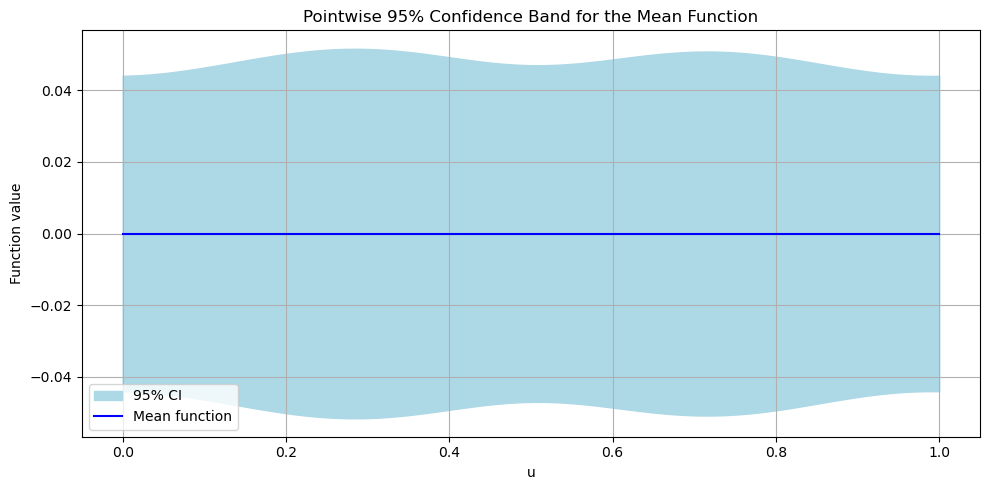

In [39]:
plt.figure(figsize=(10, 5))

# Plot the 95% confidence band as a shaded region
plt.fill_between(u_grid, lower_band, upper_band, color='lightblue', label='95% CI')

# Plot the mean function
plt.plot(u_grid, mean_curve, color='blue', label='Mean function')

# Axis labels and legend
plt.xlabel("u")
plt.ylabel("Function value")
plt.title("Pointwise 95% Confidence Band for the Mean Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()